In [2]:
# Notebook dependencies
import onnx
import onnxruntime
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

%matplotlib inline

In [3]:
# This function is from yolo3.utils.letterbox_image
def letterbox_image(image, size):
    '''Resize image with unchanged aspect ratio using padding'''
    iw, ih = image.size
    w, h = size
    scale = min(w/iw, h/ih)
    nw = int(iw*scale)
    nh = int(ih*scale)

    image = image.resize((nw,nh), Image.BICUBIC)
    new_image = Image.new('RGB', size, (128,128,128))
    new_image.paste(image, ((w-nw)//2, (h-nh)//2))
    return new_image

def preprocess(img):
    model_image_size = (608, 608)
    boxed_image = letterbox_image(img, tuple(reversed(model_image_size)))
    image_data = np.array(boxed_image, dtype='float32')
    image_data /= 255.
    image_data = np.transpose(image_data, [2, 0, 1])
    image_data = np.expand_dims(image_data, 0)
    return image_data

# Remember the coco_classes.txt file we downloaded from github earlier?
# These will provide the labels for the outputs of our ONNX model. Let's take a peek at the first 5 classes.

classes = [line.rstrip('\n') for line in open('coco_classes.txt')]
classes[0:5]

['person', 'bicycle', 'car', 'motorbike', 'aeroplane']

In [4]:
# Let us initialize an inference session with our yoloV3 model

session = onnxruntime.InferenceSession('merged_model_new.onnx')

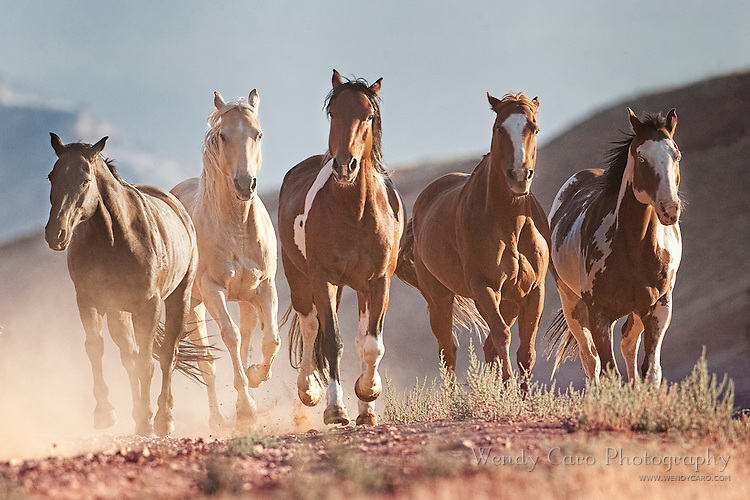

In [5]:
img = Image.open('images/horses.jpg')

# Preprocess input according to the functions specified above
img_data = preprocess(img)
img_size = np.array([img.size[1], img.size[0]], dtype=np.float32).reshape(1, 2)

# Look at what our input image looks like
img

In [6]:
# Now, let's predict using ONNX Runtime

start = time.time()
boxes, scores, indices = session.run(None, {"input": img_data, "image_shape":img_size})
end = time.time()

inference_time = np.round(end - start, 2)
print("Inference time: ", inference_time, " sec")

Inference time:  0.74  sec


In [7]:
print('Boxes:', boxes.shape)
print('Scores:', scores.shape)
print('Indices:', indices.shape)

Boxes: (1, 22743, 4)
Scores: (1, 80, 22743)
Indices: (5, 3)


In [8]:
def postprocess(boxes, scores, indices):
    objects_identified = indices.shape[0]
    out_boxes, out_scores, out_classes = [], [], []
    if objects_identified > 0:
        for idx_ in indices:
            out_classes.append(classes[idx_[1]])
            out_scores.append(scores[tuple(idx_)])
            idx_1 = (idx_[0], idx_[2])
            out_boxes.append(boxes[idx_1])
        print(objects_identified, "objects identified in source image.")
    else:
        print("No objects identified in source image.")
    return out_boxes, out_scores, out_classes, objects_identified

out_boxes, out_scores, out_classes, objects_identified = postprocess(boxes, scores, indices)

5 objects identified in source image.


<Figure size 432x288 with 0 Axes>

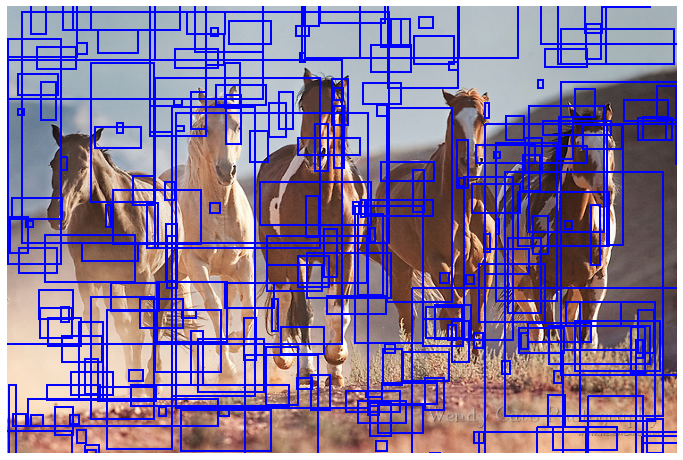

In [9]:
def display_candidate_boxes(image, boxes, image_name='sample', num_boxes=300):
    img = np.array(image)
    plt.figure()
    fig, ax = plt.subplots(1, figsize=(12,9))
    ax.imshow(img)

    candidate_boxes = np.random.choice(boxes.shape[1], num_boxes, replace=False)

    for c in candidate_boxes:
        y1, x1, y2, x2 = boxes[0][c]
        color = 'blue'
        box_h = (y2 - y1)
        box_w = (x2 - x1)
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)

    plt.axis('off')
    # save image
    plt.savefig("images/"+image_name+"-candidate.jpg", bbox_inches='tight', pad_inches=0.0)
    plt.show()
    
display_candidate_boxes(img, boxes, "horse")

<Figure size 432x288 with 0 Axes>

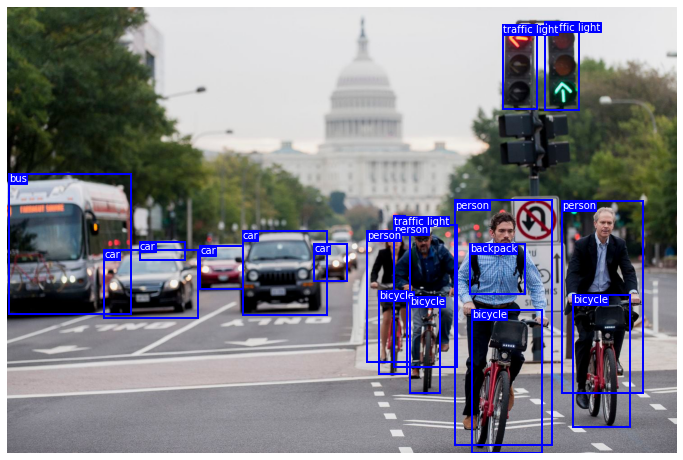

In [11]:
def display_objdetect_image(image, out_boxes, out_classes, \
                            image_name='sample', objects_identified=None, save=True):
    plt.figure()
    fig, ax = plt.subplots(1, figsize=(12,9))
    ax.imshow(image)
    if objects_identified == None:
        objects_identified = len(out_boxes)
        
    for i in range(objects_identified):
        y1, x1, y2, x2 = out_boxes[i]
        class_pred = out_classes[i]
        color = 'blue'
        box_h = (y2 - y1)
        box_w = (x2 - x1)
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(x1, y1, s=class_pred, color='white', verticalalignment='top', bbox={'color': color, 'pad': 0})

    plt.axis('off')
    # save image
    image_name = "images/"+image_name+"-det.jpg"
    plt.savefig(image_name, bbox_inches='tight', pad_inches=0.0)
    if save:
        plt.show()
    else:
        img = imread(image_name)
        os.remove(image_name)
        return img
    
display_objdetect_image(img, out_boxes, out_classes, "horse")

<Figure size 432x288 with 0 Axes>

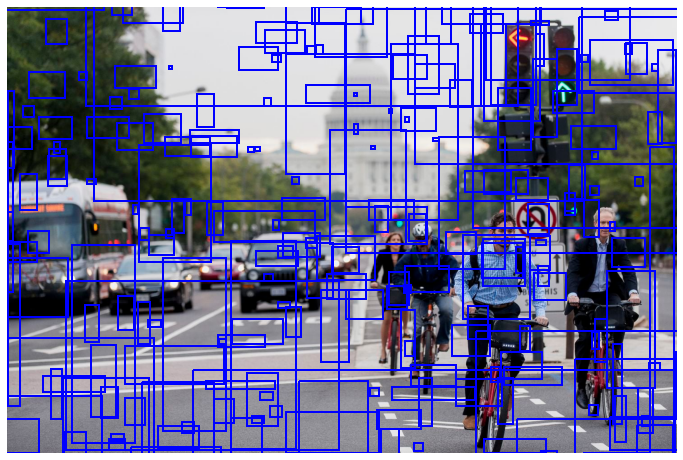

18 objects identified in source image.


<Figure size 432x288 with 0 Axes>

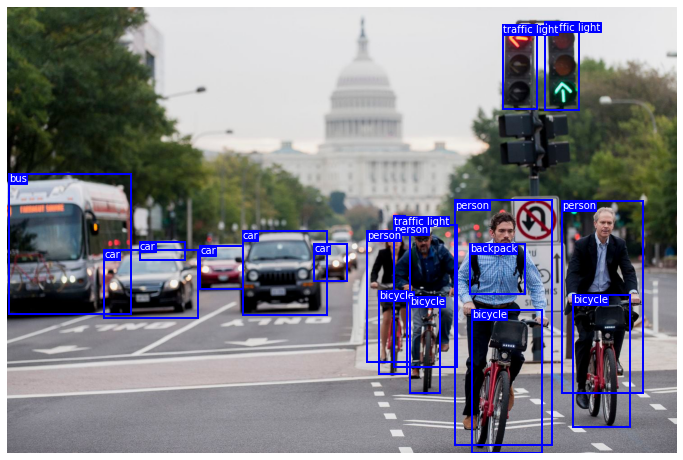

In [12]:
img = Image.open('images/road.jpg')

# input
img_data = preprocess(img)
img_size = np.array([img.size[1], img.size[0]], dtype=np.float32).reshape(1, 2)

# Now, let's predict using ONNX Runtime
boxes, scores, indices = session.run(None, {"input": img_data, "image_shape":img_size})

display_candidate_boxes(img, boxes, "road")
out_boxes, out_scores, out_classes, objects_identified = postprocess(boxes, scores, indices)
display_objdetect_image(img, out_boxes, out_classes, "road")